In [1]:
# Standard imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import importlib
import time

## 1.1 Supplied Helper Functions

In [2]:
# Supplied functions
def OneHot(z):
    '''
        y = OneHot(z)

        Applies the one-hot function to the vectors in z.
        Example:
          OneHot([[0.9, 0.1], [-0.5, 0.1]])
          returns np.array([[1,0],[0,1]])

        Input:
         z    is a 2D array of samples

        Output:
         y    is an array the same shape as z
    '''
    y = []
    # Locate the max of each row
    for zz in z:
        idx = np.argmax(zz)
        b = np.zeros_like(zz)
        b[idx] = 1.
        y.append(b)
    y = np.array(y)
    return y

def Shuffle(inputs, targets):
    '''
        s_inputs, s_targets = Shuffle(inputs, targets)

        Randomly shuffles the dataset.

        Inputs:
         inputs     array of inputs
         targets    array of corresponding targets

        Outputs:
         s_inputs   shuffled array of inputs
         s_targets  corresponding shuffled array of targets
    '''
    data = list(zip(inputs,targets))
    np.random.shuffle(data)
    s_inputs, s_targets = zip(*data)
    return np.array(s_inputs), np.array(s_targets)

def MakeBatches(data_in, data_out, batch_size=10, shuffle=True):
    '''
    batches = MakeBatches(data_in, data_out, batch_size=10)

    Breaks up the dataset into batches of size batch_size.

    Inputs:
      data_in    is a list of inputs
      data_out   is a list of outputs
      batch_size is the number of samples in each batch
      shuffle    shuffle samples first (True)

    Output:
      batches is a list containing batches, where each batch is:
                 [in_batch, out_batch]

    Note: The last batch might be incomplete (smaller than batch_size).
    '''
    N = len(data_in)
    r = range(N)
    if shuffle:
        r = np.random.permutation(N)
    batches = []
    for k in range(0, N, batch_size):
        if k+batch_size<=N:
            din = data_in[r[k:k+batch_size]]
            dout = data_out[r[k:k+batch_size]]
        else:
            din = data_in[r[k:]]
            dout = data_out[r[k:]]
        if isinstance(din, (list, tuple)):
            batches.append( [np.stack(din, dim=0) , np.stack(dout, dim=0)] )
        else:
            batches.append( [din , dout] )

    return batches


## 1.2 Cost Function

In [3]:
def CrossEntropy(y, t):
    '''
        E = CrossEntropy(y, t)

        Evaluates the mean cross entropy loss between outputs y and targets t.

        Inputs:
          y is an array holding the network outputs of size N x C
          t is an array holding the corresponding targets of size N x C

        Outputs:
          E is the mean CE of size 1 x 1
    '''
    N = y.shape[0]
    
    return np.sum(-t * np.log(y) - (1-t) * np.log(1-y)) / N

def gradCrossEntropy(y, t):
    '''
        E = gradCrossEntropy(y, t)

        Given targets t, evaluates the gradient of the mean cross entropy loss
        with respect to the output y.

        Inputs:
          y is the array holding the network's output of size N x C
          t is an array holding the corresponding targets of size N x C

        Outputs:
          dEdy is the gradient of CE with respect to output y of size N x C
    '''
    N = y.shape[0]
    
    return ( (-t / y) + (1-t) / (1-y) ) / N

def MSE(y, t):
    '''
        E = MSE(y, t)

        Evaluates the mean squared error loss between outputs y and targets t.

        Inputs:
          y is the array holding the network's output of size N x C
          t is an array holding the corresponding targets of size N x C

        Outputs:
          E is the MSE of size 1 x 1
    '''
    N = y.shape[0]
    
    return np.sum(np.square(y - t)) / (2*N)

def gradMSE(y, t):
    '''
        E = gradMSE(y, t)

        Given targets t, evaluates the gradient of the mean squared error loss
        with respect to the output y.

        Inputs:
          y is the array holding the network's output of size N x C
          t is an array holding the corresponding targets of size N x C

        Outputs:
          dEdy is the gradient of MSE with respect to output y of size N x C
    '''
    N = y.shape[0]
    
    return (y - t) / N

def CategoricalCE(outputs, t):
    return -np.sum(t * np.log(outputs)) / len(t)

## 1.3 Layer Class

In [4]:
class Layer():

    def __init__(self, n_nodes, act='logistic'):
        '''
            lyr = Layer(n_nodes, act='logistic')

            Creates a layer object.

            Inputs:
             n_nodes  the number of nodes in the layer
             act      specifies the activation function
                      Use 'logistic' or 'identity'
        '''
        self.N = n_nodes  # number of nodes in this layer
        self.h = []       # node activities
        self.z = []
        self.b = np.zeros(self.N)  # biases

        # Activation functions
        if act=='logistic':
            self.sigma = self.Logistic
            self.sigma_p = self.Logistic_p
        elif act=='identity':
            self.sigma = self.Identity
            self.sigma_p = self.Identity_p
        elif act=='softmax':
            self.sigma = self.Softmax
            self.sigma_p = None
        else:
            print('Error: Activation function '+act+' not implemented!')

    def Logistic(self):
        return 1. / (1. + np.exp(-self.z))
    def Logistic_p(self):
        return self.h * (1.-self.h)
    def Identity(self):
        return self.z
    def Identity_p(self):
        return np.ones_like(self.h)
    def Softmax(self):
        v = np.exp(self.z)
        s = np.sum(v, axis=1)
        return v/np.tile(s[:,np.newaxis], [1,np.shape(v)[1]])

## 1.4 Network Class

In [5]:
class Network():

    def __init__(self, sizes, type='classifier'):
        '''
            net = Network(sizes, type='classifier')

            Creates a Network and saves it in the variable 'net'.

            Inputs:
              sizes is a list of integers specifying the number
                  of nodes in each layer
                  eg. [5, 20, 3] will create a 3-layer network
                      with 5 input, 20 hidden, and 3 output nodes
              type can be either 'Bernoulli', 'classifier' or 'regression',
                   and sets the activation function on the output layer,
                   as well as the loss function.
                   'Bernoulli':  logistic, cross entropy
                   'classifier': softmax, categorical cross entropy
                   'regression': linear, mean squared error
        '''
        self.n_layers = len(sizes)
        self.lyr = []    # a list of Layers
        self.W = []      # Weight matrices, indexed by the layer below it

        self.type = type # 'Bernoulli', 'classifier', 'regression'

        self.cost_history = []  # keeps track of the cost as learning progresses

        # Two common types of networks
        # The member variable self.Loss refers to one of the implemented
        # loss functions: MSE, or CrossEntropy.
        # Call it using self.Loss(t)
        if type=='Bernoulli':
            self.Loss = CrossEntropy
            self.gradLoss = gradCrossEntropy
            activation = 'logistic'
        elif type=='classifier':
            self.Loss = CategoricalCE
            self.gradLoss = None
            activation = 'softmax'
        elif type=='regression':
            self.Loss = MSE
            self.gradLoss = gradMSE
            activation = 'identity'
        else:
            print('Error: Network type '+type+' not implemented!')

        # Create and add Layers (using logistic for hidden layers)
        for n in sizes[:-1]:
            self.lyr.append( Layer(n) )

        # For the top layer, we use the appropriate activtaion function
        self.lyr.append( Layer(sizes[-1], act=activation) )

        # Randomly initialize weight matrices
        for idx in range(self.n_layers-1):
            m = self.lyr[idx].N
            n = self.lyr[idx+1].N
            temp = np.random.normal(size=[m,n])/np.sqrt(m)
            self.W.append(temp)
    
    def FeedForward(self, x):
        '''
            y = net.FeedForward(x)

            Runs the network forward, starting with x as input.
            Returns the activity of the output layer.

            All node use 
            Note: The activation function used for the output layer
            depends on what self.Loss is set to.
        '''
        x = np.array(x)  # Convert input to array, in case it's not
        self.lyr[0].h = x

        for i in range(self.n_layers-1):
            layer = self.lyr[i+1]
            weight = self.W[i]

            layer.z = np.dot(x, weight) + layer.b
            layer.h = layer.sigma()
            x = layer.h

        return x

    def TopGradient(self, t):
        '''
            dEdz = net.TopGradient(targets)

            Computes and returns the gradient of the cost with respect to the input current
            to the output nodes.

            Inputs:
              targets is a batch of targets corresponding to the last FeedForward run

            Outputs:
              dEdz is a batch of gradient vectors corresponding to the output nodes
        '''
        if self.type=='classifier':
            return ( self.lyr[-1].h - t ) / len(t)
        elif self.type=='regression':
            return ( self.lyr[-1].h - t ) / len(t)
        elif self.type=='Bernoulli':
            return ( self.lyr[-1].h - t ) / len(t)
        return self.gradLoss(self.lyr[-1].h, t) * self.lyr[-1].sigma_p()
    
    
    def BackProp(self, t, lrate=0.05):
        '''
            net.BackProp(targets, lrate=0.05)

            Given the current network state and targets t, updates the connection
            weights and biases using the backpropagation algorithm.

            Inputs:
             t      an array of targets (number of samples must match the
                    network's output)
             lrate  learning rate
        '''
        t = np.array(t)  # convert t to an array, in case it's not

        # Error gradient for top layer
        dEdz = self.TopGradient(t)

        # Loop down through the layers
        # Start second-from-the-top, and go down to layer 0
        for i in range(self.n_layers-2, -1, -1):
            pre = self.lyr[i]

            # Gradient w.r.t. weights
            dEdW = pre.h.T @ dEdz

            # Gradient w.r.t. biases
            dEdb = np.sum(dEdz, axis=0)

            # Use Sigma'
            # Project error gradient down to layer below
            dEdz = ( dEdz @ self.W[i].T ) * pre.sigma_p()

            # Update weights and biases
            self.W[i] -= lrate*dEdW
            self.lyr[i+1].b -= lrate*dEdb


            
    def Learn(self, inputs, targets, lrate=0.05, epochs=1, progress=True):
        '''
            Network.Learn(data, lrate=0.05, epochs=1, progress=True)

            Run through the dataset 'epochs' number of times, incrementing the
            network weights after each epoch.

            Inputs:
              data is a list of 2 arrays, one for inputs, and one for targets
              lrate is the learning rate (try 0.001 to 0.5)
              epochs is the number of times to go through the training data
              progress (Boolean) indicates whether to show cost
        '''
        for i in range(epochs):
            y = self.FeedForward(inputs)
            self.BackProp(targets, lrate)
            if progress:
                self.cost_history.append(self.Loss(y, targets))
                if i % 20 == 0:
                    print(f"Epoch {i}: Cost = {self.cost_history[-1]}")
                    
                    
    def SGD(self, inputs, targets, lrate=0.05, epochs=1, batch_size=10):
        '''
            progress = net.SGD(inputs, targets, lrate=0.05, epochs=1, batch_size=10)

            Performs Stochastic Gradient Descent on the network.
            Run through the dataset in batches 'epochs' number of times, incrementing the
            network weights after each batch. For each epoch, it shuffles the dataset.

            Inputs:
              inputs  is an array of input samples
              targets is a corresponding array of targets
              lrate   is the learning rate (try 0.001 to 5)
              epochs  is the number of times to go through the training data
              batch_size is the number of samples for each batch

            Outputs:
              progress is an (epochs)x2 array with epoch in the first column, and
                      cost in the second column
        '''
        loss_history = []
        for k in range(epochs):
            batches = MakeBatches(inputs, targets, batch_size=batch_size, shuffle=True)
            for mini_batch in batches:
                self.FeedForward(mini_batch[0])
                self.BackProp(mini_batch[1], lrate=lrate)

            loss_history.append([k, self.Evaluate(inputs, targets)])

        return np.array(loss_history)
    

    def Evaluate(self, inputs, targets):
        '''
            E = net.Evaluate(data)

            Computes the average loss over the supplied dataset.

            Inputs
             inputs  is an array of inputs
             targets is a list of corresponding targets

            Outputs
             E is a scalar, the average loss
        '''
        y = self.FeedForward(inputs)
        return self.Loss(y, targets)

    def ClassificationAccuracy(self, inputs, targets):
        '''
            a = net.ClassificationAccuracy(data)
            
            Returns the fraction (between 0 and 1) of correct one-hot classifications
            in the dataset.
        '''
        y = self.FeedForward(inputs)
        yb = OneHot(y)
        n_incorrect = np.sum(yb!=targets) / 2.
        return 1. - float(n_incorrect) / len(inputs)

## 1.5 Binary Classification

### 1.5.1 Create a Classification Dataset

In [6]:
# 5 Classes in 8-Dimensional Space
np.random.seed(15)
noise = 0.1
InputClasses = np.array([[1,0,1,0,0,1,1,0],
                         [0,1,0,1,0,1,0,1],
                         [0,1,1,0,1,0,0,1],
                         [1,0,0,0,1,0,1,1],
                         [1,0,0,1,0,1,0,1]], dtype=float)
OutputClasses = np.array([[1,0,0,0,0],
                          [0,1,0,0,0],
                          [0,0,1,0,0],
                          [0,0,0,1,0],
                          [0,0,0,0,1]], dtype=float)
n_input = np.shape(InputClasses)[1]
n_output = np.shape(OutputClasses)[1]
n_classes = np.shape(InputClasses)[0]

# Create a training dataset
n_samples = 100
training_output = []
training_input = []
for idx in range(n_samples):
    k = np.random.randint(n_classes)
    x = InputClasses[k,:] + np.random.normal(size=n_input)*noise
    t = OutputClasses[k,:]
    training_input.append(x)
    training_output.append(t)

# Create a test dataset
n_samples = 100
test_output = []
test_input = []
for idx in range(n_samples):
    k = np.random.randint(n_classes)
    x = InputClasses[k,:] + np.random.normal(size=n_input)*noise
    t = OutputClasses[k,:]
    test_input.append(x)
    test_output.append(t)

train = [np.array(training_input), np.array(training_output)]
test = [np.array(test_input), np.array(test_output)]

### 1.5.2 Neural Network Model

In [7]:
# Create a Network
net = Network([n_input, 18, n_output], type='classifier')

In [8]:
CE = net.Evaluate(train[0], train[1])

In [9]:
# Evaluate it before training
CE = net.Evaluate(train[0], train[1])
accuracy = net.ClassificationAccuracy(train[0], train[1])
print('Cross Entropy = '+str(CE))
print('     Accuracy = '+str(accuracy*100.)+'%')

Cross Entropy = 1.7049945764138175
     Accuracy = 26.0%


In [10]:
net.Learn(train[0], train[1], epochs=500, lrate=1.)

Epoch 0: Cost = 1.7049945764138175
Epoch 20: Cost = 0.6640659344126957
Epoch 40: Cost = 0.20769143733901146
Epoch 60: Cost = 0.1003319564205297
Epoch 80: Cost = 0.062001148347975266
Epoch 100: Cost = 0.04357560903616135
Epoch 120: Cost = 0.03308110404027269
Epoch 140: Cost = 0.026419890752775732
Epoch 160: Cost = 0.02186382718834185
Epoch 180: Cost = 0.01857353896584927
Epoch 200: Cost = 0.016097476484641153
Epoch 220: Cost = 0.014173189935192437
Epoch 240: Cost = 0.012638618631637495
Epoch 260: Cost = 0.011388705280675593
Epoch 280: Cost = 0.010352574653862941
Epoch 300: Cost = 0.009480793962473016
Epoch 320: Cost = 0.008737900515258119
Epoch 340: Cost = 0.008097831775590066
Epoch 360: Cost = 0.007541028651033376
Epoch 380: Cost = 0.007052541620586019
Epoch 400: Cost = 0.006620758544241931
Epoch 420: Cost = 0.006236529450157108
Epoch 440: Cost = 0.00589255153684604
Epoch 460: Cost = 0.005582928766231716
Epoch 480: Cost = 0.0053028510704211974


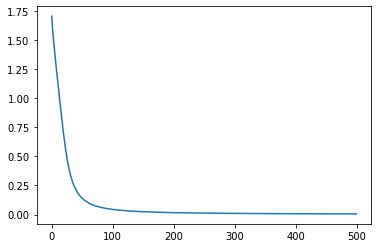

In [11]:
plt.plot(net.cost_history);

### 1.5.3 Evaluate it After Training

In [12]:
print('Training Set')
CE = net.Evaluate(train[0], train[1])
accuracy = net.ClassificationAccuracy(train[0], train[1])
print('Cross Entropy = '+str(CE))
print('     Accuracy = '+str(accuracy*100.)+'%')

Training Set
Cross Entropy = 0.005048357063823858
     Accuracy = 100.0%


In [13]:
print('Test Set')
CE = net.Evaluate(test[0], test[1])
accuracy = net.ClassificationAccuracy(test[0], test[1])
print('Cross Entropy = '+str(CE))
print('     Accuracy = '+str(accuracy*100.)+'%')

Test Set
Cross Entropy = 0.005664813379256483
     Accuracy = 100.0%


## 1.6 Regression

### 1.6.1 Create a Regression Dataset

In [14]:
# 1D -> 1D (linear mapping)
np.random.seed(846)
n_input = 1
n_output = 1
slope = np.random.rand() - 0.5
intercept = np.random.rand()*2. - 1.

def myfunc(x):
    return slope*x+intercept

# Create a training dataset
n_samples = 200
training_output = []
training_input = []
xv = np.linspace(-1, 1, n_samples)
for idx in range(n_samples):
    #x = np.random.rand()*2. - 1.
    x = xv[idx]
    t = myfunc(x) + np.random.normal(scale=0.1)
    training_input.append(np.array([x]))
    training_output.append(np.array([t]))

# Create a testing dataset
n_samples = 50
test_input = []
test_output = []
xv = np.linspace(-1, 1, n_samples)
for idx in range(n_samples):
    #x = np.random.rand()*2. - 1.
    x = xv[idx] + np.random.normal(scale=0.1)
    t = myfunc(x) + np.random.normal(scale=0.1)
    test_input.append(np.array([x]))
    test_output.append(np.array([t]))

# Create a perfect dataset
n_samples = 100
perfect_input = []
perfect_output = []
xv = np.linspace(-1, 1, n_samples)
for idx in range(n_samples):
    #x = np.random.rand()*2. - 1.
    x = xv[idx]
    t = myfunc(x)
    perfect_input.append(np.array([x]))
    perfect_output.append(np.array([t]))
    
train = [np.array(training_input), np.array(training_output)]
test = [np.array(test_input), np.array(test_output)]
perfect = [np.array(perfect_input), np.array(perfect_output)]

### 1.6.2 Neural Network Model

In [15]:
net = Network([1, 10, 1], type='regression')
net2 = Network([1, 10, 1], type='regression')
# deep copy the weight matrix from net to net2
for i in range(len(net.W)):
    net2.W[i] = np.copy(net.W[i])

In [16]:
# Evaluate it before training
mse = net.Evaluate(train[0], train[1])
print('MSE = '+str(mse))
# Evaluate it before training
mse2 = net2.Evaluate(train[0], train[1])
print('MSE2 = '+str(mse2))

MSE = 0.17876598078770747
MSE2 = 0.17876598078770747


### 1.6.3 Training

In [17]:
net.Learn(train[0], train[1], epochs=300)

Epoch 0: Cost = 0.17876598078770747
Epoch 20: Cost = 0.10604681325290136
Epoch 40: Cost = 0.08184937918113253
Epoch 60: Cost = 0.06385589374826238
Epoch 80: Cost = 0.05024314241843017
Epoch 100: Cost = 0.039829362448087095
Epoch 120: Cost = 0.0318063687940261
Epoch 140: Cost = 0.025600078239208835
Epoch 160: Cost = 0.020789935628921747
Epoch 180: Cost = 0.017060421844050506
Epoch 200: Cost = 0.014170662243563998
Epoch 220: Cost = 0.011934572393487648
Epoch 240: Cost = 0.0102073324873131
Epoch 260: Cost = 0.008875795370152784
Epoch 280: Cost = 0.007851437244578282


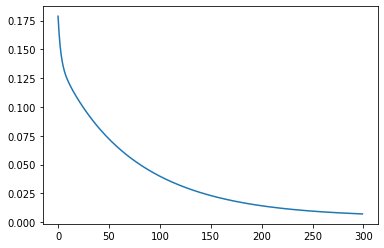

In [18]:
plt.plot(net.cost_history);

### 1.6.4 Evaluate it After Training

In [19]:
# On training dataset
mse = net.Evaluate(train[0], train[1])
print('Training MSE = '+str(mse))

Training MSE = 0.0070650250589358084


In [20]:
# On test dataset
mse = net.Evaluate(test[0], test[1])
print('Test MSE = '+str(mse))

Test MSE = 0.008650812311897614


In [21]:
# Evaluate our model and the TRUE solution (since we know it)
s = np.linspace(-1, 1, 200)
y = net.FeedForward(np.array([s]).T)
p = [myfunc(x) for x in s]

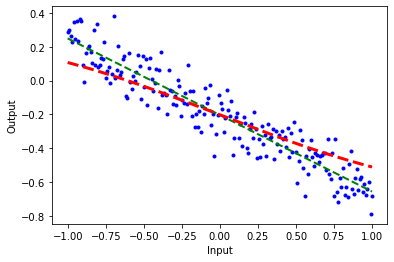

In [22]:
# Plot the training data,
# as well as out model and the true model
plt.plot(training_input, training_output, 'b.')
plt.plot(s,p, 'g--', linewidth=2)
plt.plot(s,y, 'r--', linewidth=3)
plt.xlabel('Input')
plt.ylabel('Output');

## 1.7 Multiclass Classifier

### 1.7.1 Craete a Classification Dataset

In [23]:
def ClassPlot(x, y):
    # FeedForward
    yc = OneHot(y)
    colour_options = ['y', 'b', 'r', 'g', 'k']
    cidx = np.argmax(yc, axis=1)
    colours = [colour_options[k] for k in cidx]
    plt.scatter(x[:,0],x[:,1], color=colours, marker='.')
    plt.axis('equal');

def GaussianCluster(mu, sa, N, theta=0.):
    theta_rad = theta/180*np.pi
    c, s = np.cos(theta_rad), np.sin(theta_rad)
    R = np.array([[c,-s],[s,c]])
    M = R @ np.diag(sa) @ R.T
    y = np.random.multivariate_normal(mu, M, N)
    return y

def CreateDataset(params):
    '''
        train, test = CreateDataset(params)
        
        Creates a dataset using a bunch of Gaussian clouds.
        
        Inputs:
          params is a list of 5-tuples. Each tuple (or list)
             describes a 2-D Gaussian cloud:
             1) the mean
             2) standard deviation along x and y directions
             3) rotation of cloud (degrees counter-clockwise)
             4) class index
             5) number of points
             
        Outputs:
          train is a list containing 2 arrays
             - the first array contains the training inputs,
               one per row
             - the second array contains the corresponding classes
          test has the same structure as train, but with
               half the number of samples
    '''
    train_inputs = []
    train_outputs = []
    test_inputs = []
    test_outputs = []
    all_c = [p[3] for p in params]
    n_classes = np.max(all_c)
    for p in params:
        xx = GaussianCluster(p[0], p[1], p[4], theta=p[2])
        yy = np.zeros((p[4], n_classes+1))
        yy[:,p[3]] = 1.
        train_inputs.append(xx)
        train_outputs.append(yy)
        xtest = GaussianCluster(p[0], p[1], int(p[4]/2), theta=p[2])
        ytest = np.zeros((int(p[4]/2), n_classes+1))
        ytest[:,p[3]] = 1.
        test_inputs.append(xtest)
        test_outputs.append(ytest)
    train = [np.vstack(train_inputs), np.vstack(train_outputs)]
    test = [np.vstack(test_inputs), np.vstack(test_outputs)]
    return train, test

# 0=y, 1=b, 2=r
params = [[[0.5, 0.5],   [0.025, 0.01],  -45, 0, 50],
          [[-0.5,-0.5],  [0.025, 0.01],  -45, 0, 50],
          [[-0.3,-0.35], [0.04,0.01],     10, 0, 80],
          [[0.6,0],      [0.01,0.01],      0, 0, 50],
          [[0.1,-0.04],  [0.1,0.005],     20, 0, 80],
          [[0.5,-0.5],   [0.02,0.01],     45, 1, 50],
          [[0,0.6],      [0.01,0.01],      0, 1, 50],
          [[-0.5,0.1],   [0.02,0.01],     30, 1, 80],
          [[-0.5,0.5],   [0.02,0.01],     45, 2, 50],
          [[0,-0.6],     [0.01,0.01],      0, 2, 50],
          [[0.2,0.3],    [0.01,0.004],     0, 2, 80],
          [[-0.2,0.37],  [0.02,0.005],   -30, 2, 50],
          [[0.25,-0.3],  [0.005,0.01],     0, 3, 60],
          [[-0.1,0.1],   [0.01,0.01],    -30, 3, 50]
         ]

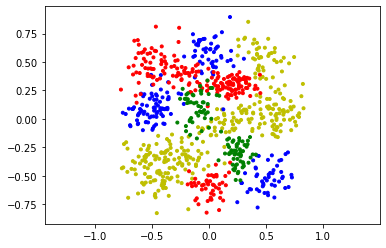

In [24]:
# Create an interesting dataset
train, test = CreateDataset(params)
ClassPlot(train[0], train[1]);

### 1.7.2 Create and Train a Neural Network

In [25]:
# Create a network that can solve the problem
net = Network(sizes=[2, 128, 128, 4], type='classifier')

In [26]:
train, test = CreateDataset(params)

In [27]:
# Train and evaluate the model
progress = net.SGD(train[0], train[1], epochs=400, lrate=0.1)

### 1.7.3 Evaluate Model

In [28]:
# Classification accuracy on training and test datasets
train_acc = net.ClassificationAccuracy(train[0], train[1])
test_acc = net.ClassificationAccuracy(test[0], test[1])
print(f"Training accurancy is {train_acc}, test accurancy is {test_acc}")

Training accurancy is 0.9337349397590361, test accurancy is 0.9084337349397591


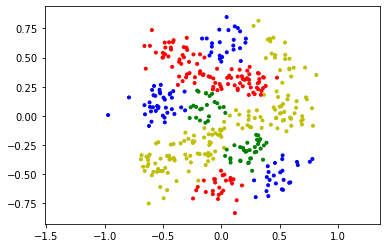

In [29]:
# Plot coloured clouds
ClassPlot(test[0], net.FeedForward(test[0]));

## 1.8 Regularization

### 1.8.1 Modification of Network

In [37]:
class RobustNetwork(Network):
        
    def BackProp(self, t, lrate=0.05, decay=0.):
        '''
            net.BackProp(targets, lrate=0.05, decay=0.)
            
            Given the current network state and targets t, updates the connection
            weights and biases using the backpropagation algorithm.
            
            Inputs:
             t      an array of targets (number of samples must match the
                    network's output)
             lrate  learning rate
             decay  is the coefficient for weight/bias decay
        '''
            
        t = np.array(t)  # convert t to an array, in case it's not

        # Error gradient for top layer (same for both types)
        dEdz = self.TopGradient(t)

        # Loop down through the layers
        # Start second-from-the-top, and go down to layer 0
        for i in range(self.n_layers-2, -1, -1):
            pre = self.lyr[i]

            # Gradient w.r.t. weights
            dEdW = pre.h.T @ dEdz
            # NOTE: we will use L2 Norm
            dEdW += 2 * decay * self.W[i]

            # Gradient w.r.t. biases
            dEdb = np.sum(dEdz, axis=0)
            # NOTE: we will use L2 Norm
            dEdb += 2 * decay * self.lyr[i+1].b
            
            # Use Sigma'
            # Project error gradient down to layer below
            dEdz = ( dEdz @ self.W[i].T ) * pre.sigma_p()

            # Update weights and biases
            self.W[i] -= lrate*dEdW
            self.lyr[i+1].b -= lrate*dEdb
            

    
    def SGD(self, inputs, targets, lrate=0.05, epochs=1, batch_size=10, decay=0):
        '''
            progress = net.SGD(inputs, targets, lrate=0.05, epochs=1, batch_size=10, decay=0)

            Performs Stochastic Gradient Descent on the network.
            Run through the dataset in batches 'epochs' number of times, incrementing the
            network weights after each batch. For each epoch, it shuffles the dataset.

            Inputs:
              inputs  is an array of input samples
              targets is a corresponding array of targets
              lrate   is the learning rate (try 0.001 to 5)
              epochs  is the number of times to go through the training data
              batch_size is the number of samples for each batch
              decay   is the decay coefficient for the weights and biases
              
            Outputs:
              progress is an (epochs)x2 array with epoch in the first column, and 
                      cost in the second column
        '''
        loss_history = []
        for k in range(epochs):
            batches = MakeBatches(inputs, targets, batch_size=batch_size, shuffle=True)
            for mini_batch in batches:
                self.FeedForward(mini_batch[0])
                self.BackProp(mini_batch[1], lrate=lrate, decay=decay)

            loss_history.append([k, self.Evaluate(inputs, targets)])

        return np.array(loss_history)

### 1.8.2 Create a Noise Dataset

In [38]:
def GenerateDatasets(n, seed=None):
    # 1D -> 1D (line mapping)
    n_input = 1
    n_output = 1
    noise = 0.5

    if seed:
        np.random.seed(seed)
    a = np.random.rand()
    m = np.random.rand() + 0.5
    b = np.random.rand()-0.5

    def myfunc(x):
        return a*x**2 + m*x + b

    # Create a training dataset
    n_samples = n
    training_output = []
    training_input = []
    xv = np.linspace(-1, 1, n_samples)
    for idx in range(n_samples):
        #x = np.random.rand()*2. - 1.
        x = xv[idx]
        t = myfunc(x) + np.random.normal(scale=noise)
        training_input.append(np.array([x]))
        training_output.append(np.array([t]))

    # Create a testing dataset
    test_input = []
    test_output = []
    n_test_samples = 300
    xv = np.linspace(-1, 1, n_test_samples)
    for idx in range(n_test_samples):
        #x = np.random.rand()*2. - 1.
        x = xv[idx] #+ np.random.normal(scale=0.1)
        t = myfunc(x) + np.random.normal(scale=noise)
        test_input.append(np.array([x]))
        test_output.append(np.array([t]))


    train = [np.array(training_input), np.array(training_output)]
    test = [np.array(test_input), np.array(test_output)]
    
    return train, test

In [44]:
# Generate the training and testing datasets
P = 5
train, test = GenerateDatasets(P)

### 1.8.3 Comparison between Net with and without Decay

In [45]:
import copy
# Create a RobustNetwork, using MSE and identity output
original_net = RobustNetwork(sizes=[1,10,1], type='regression')
decay_net = copy.deepcopy(original_net)

In [46]:
# For Original Net
print("="*10 + " Net without Decay " + "="*10)
loss_history = original_net.SGD(inputs=train[0], targets=train[1], lrate=0.1, epochs=5000, batch_size=5, decay=0.)
print(f"Final training loss is {loss_history[-1][-1]}")
test_loss = original_net.Evaluate(inputs=test[0], targets=test[1])
print(f"Test loss is {test_loss}")

========== Net without Decay ==========
Final training loss is 0.0023692955196126277
Test loss is 0.11933261606930787


In [47]:
# For Decay Net
print("="*10 + " Net with Decay " + "="*10)
loss_history = decay_net.SGD(inputs=train[0], targets=train[1], lrate=0.1, epochs=5000, batch_size=5, decay=0.01)
print(f"Final training loss is {loss_history[-1][-1]}")
test_loss = decay_net.Evaluate(inputs=test[0], targets=test[1])
print(f"Test loss is {test_loss}")

========== Net with Decay ==========
Final training loss is 0.07013880103222192
Test loss is 0.15603876485270143


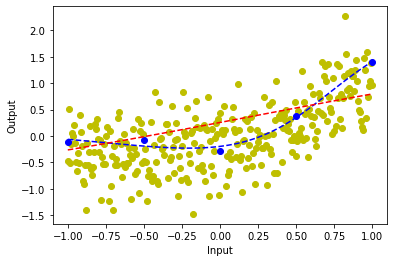

In [48]:
# Plot Training and Test data
# we plot test set first in case it cover points in training set
plt.plot(test[0], test[1], 'yo')
plt.plot(train[0], train[1], 'bo')
plt.xlabel('Input'); plt.ylabel('Output');

# Plot original_net and dropout_net models
xv = np.linspace(-1, 1, 100)
yv = [original_net.FeedForward([xx]) for xx in xv]
plt.plot(xv, yv, 'b--')

xv = np.linspace(-1, 1, 100)
yv = [decay_net.FeedForward([xx]) for xx in xv]
plt.plot(xv, yv, 'r--')

### 1.8.4 Average Performance

In [49]:
# Loop for 10 trials
trials = 10

original_train_losses = []
decay_train_losses = []
original_test_losses = []
decay_test_losses = []

for k in range(trials):

    original_net = RobustNetwork(sizes=[1,10,1], type='regression')
    decay_net = copy.deepcopy(original_net)
    
    P = 5
    train, test = GenerateDatasets(P)
    
    # training without weight decay
    original_train_loss = original_net.SGD(inputs=train[0], targets=train[1], lrate=0.1, epochs=5000, batch_size=5, decay=0.)
    original_test_loss = original_net.Evaluate(inputs=test[0], targets=test[1])
    original_train_losses.append(original_train_loss[-1][-1])
    original_test_losses.append(original_test_loss)

    # training with weight decay
    decay_train_loss = decay_net.SGD(inputs=train[0], targets=train[1],  lrate=0.1, epochs=5000, batch_size=5, decay=0.01)
    decay_test_loss = decay_net.Evaluate(inputs=test[0], targets=test[1])
    decay_train_losses.append(decay_train_loss[-1][-1])
    decay_test_losses.append(decay_test_loss)

In [50]:
# Compute the mean cost over the 10 trials

orig_train, decay_train, orig_test, decay_test = np.average(original_train_losses), np.average(decay_train_losses), np.average(original_test_losses), np.average(decay_test_losses)

print('Training set, without decay,   cost = '+str(orig_train))
print('Training set, with decay=0.01, cost = '+str(decay_train))
print('Test set,     without decay,   cost = '+str(orig_test))
print('Test set,     with decay=0.01, cost = '+str(decay_test))

Training set, without decay,   cost = 0.030749154190560523
Training set, with decay=0.01, cost = 0.09279066964959083
Test set,     without decay,   cost = 0.16768192147009384
Test set,     with decay=0.01, cost = 0.15226195781126883
